In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels
import warnings
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [43]:
lang_codes = ["ja", "ko", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
df_interventions = pd.read_csv('data/interventions.csv')

In [34]:
pre_covid_dfs = []
dur_covid_dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

for language in lang_codes:
    language_data = agg[language]
    language_data_mobile = agg[language + '.m']
    
    all_sum = pd.Series(language_data['sum']) + pd.Series(language_data_mobile['sum'])
    
    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)

    closure_date = df_interventions[df_interventions['lang'] == language]['School closure'].iloc[0]
    for topic, topic_data in language_data["topics"].items():
        if topic[:9] == 'Geography':
            continue

        topic_data_mobile = language_data_mobile["topics"][topic]
        topic_sum = pd.Series(topic_data['sum']) + pd.Series(topic_data_mobile['sum']) # number of pageviews per day for a topic
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'language': [language] * len(topic_sum),
            'date': pd.to_datetime(topic_sum.index),
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        pre_covid_dfs.append(topic_df[topic_df['date'] < closure_date])
        dur_covid_dfs.append(topic_df[topic_df['date'] >= closure_date])
        
pre_covid_df = pd.concat(pre_covid_dfs, ignore_index=True)
dur_covid_df = pd.concat(dur_covid_dfs, ignore_index=True)
display(pre_covid_df)

,pageviews,language,date,topic,proportion
0,8345845,ja,2018-01-01,Culture.Biography.Biography*,0.276752
1,7516614,ja,2018-01-02,Culture.Biography.Biography*,0.242172
2,7911263,ja,2018-01-03,Culture.Biography.Biography*,0.235252
3,7490691,ja,2018-01-04,Culture.Biography.Biography*,0.221156
4,7623786,ja,2018-01-05,Culture.Biography.Biography*,0.227700
...,...,...,...,...,...
393226,1166597,de,2020-03-09,STEM.Technology,0.040091
393227,1213508,de,2020-03-10,STEM.Technology,0.041269
393228,1155507,de,2020-03-11,STEM.Technology,0.042743
393229,1029715,de,2020-03-12,STEM.Technology,0.040984


In [35]:
df = pre_covid_df[(pre_covid_df.date == '2018-01-01') & (pre_covid_df.language == 'ja')]
topics_with_star = df[df['topic'].str.endswith('*')]['topic'].unique()
prefixes_to_remove = [topic.rsplit('.', 1)[0] for topic in topics_with_star]
filtered_df = df[~df['topic'].apply(lambda x: any(x.startswith(prefix) for prefix in prefixes_to_remove)) | df['topic'].str.endswith('*')]
filtered_df['proportion'].sum()

1.014428923198933

In [39]:
pre_covid_prop = pre_covid_df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['median'])['proportion'].reset_index()
dur_covid_prop = dur_covid_df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['median'])['proportion'].reset_index()
pre_covid_prop['country'] = pre_covid_prop.language.map(code_dict)
dur_covid_prop['country'] = dur_covid_prop.language.map(code_dict)

topics = pre_covid_prop.topic.unique()
pre_covid_correlation = []
dur_covid_correlation = []

for topic in topics:
    for dim in hofstede.columns:
        pre_median_vals = pd.Series(pre_covid_prop[pre_covid_prop.topic == topic]['median'].values, index=pre_covid_prop[pre_covid_prop.topic == topic]['country'])
        dur_median_vals = pd.Series(dur_covid_prop[dur_covid_prop.topic == topic]['median'].values, index=dur_covid_prop[dur_covid_prop.topic == topic]['country'])
        
        pre_covid_correlation.append({'topic': topic, 'dimension': dim, 'correlation': hofstede[dim].corr(pre_median_vals)})
        dur_covid_correlation.append({'topic': topic, 'dimension': dim, 'correlation': hofstede[dim].corr(dur_median_vals)})
        
pre_covid_corr_df = pd.DataFrame(pre_covid_correlation).pivot(index='topic', columns='dimension', values='correlation')
dur_covid_corr_df = pd.DataFrame(dur_covid_correlation).pivot(index='topic', columns='dimension', values='correlation')

In [40]:
df = pre_covid_prop
filtered_df = df[~df['topic'].apply(lambda x: any(x.startswith(prefix) for prefix in prefixes_to_remove)) | df['topic'].str.endswith('*')]
filtered_df[filtered_df.language == 'ja']['median'].sum()

0.9876187868149234

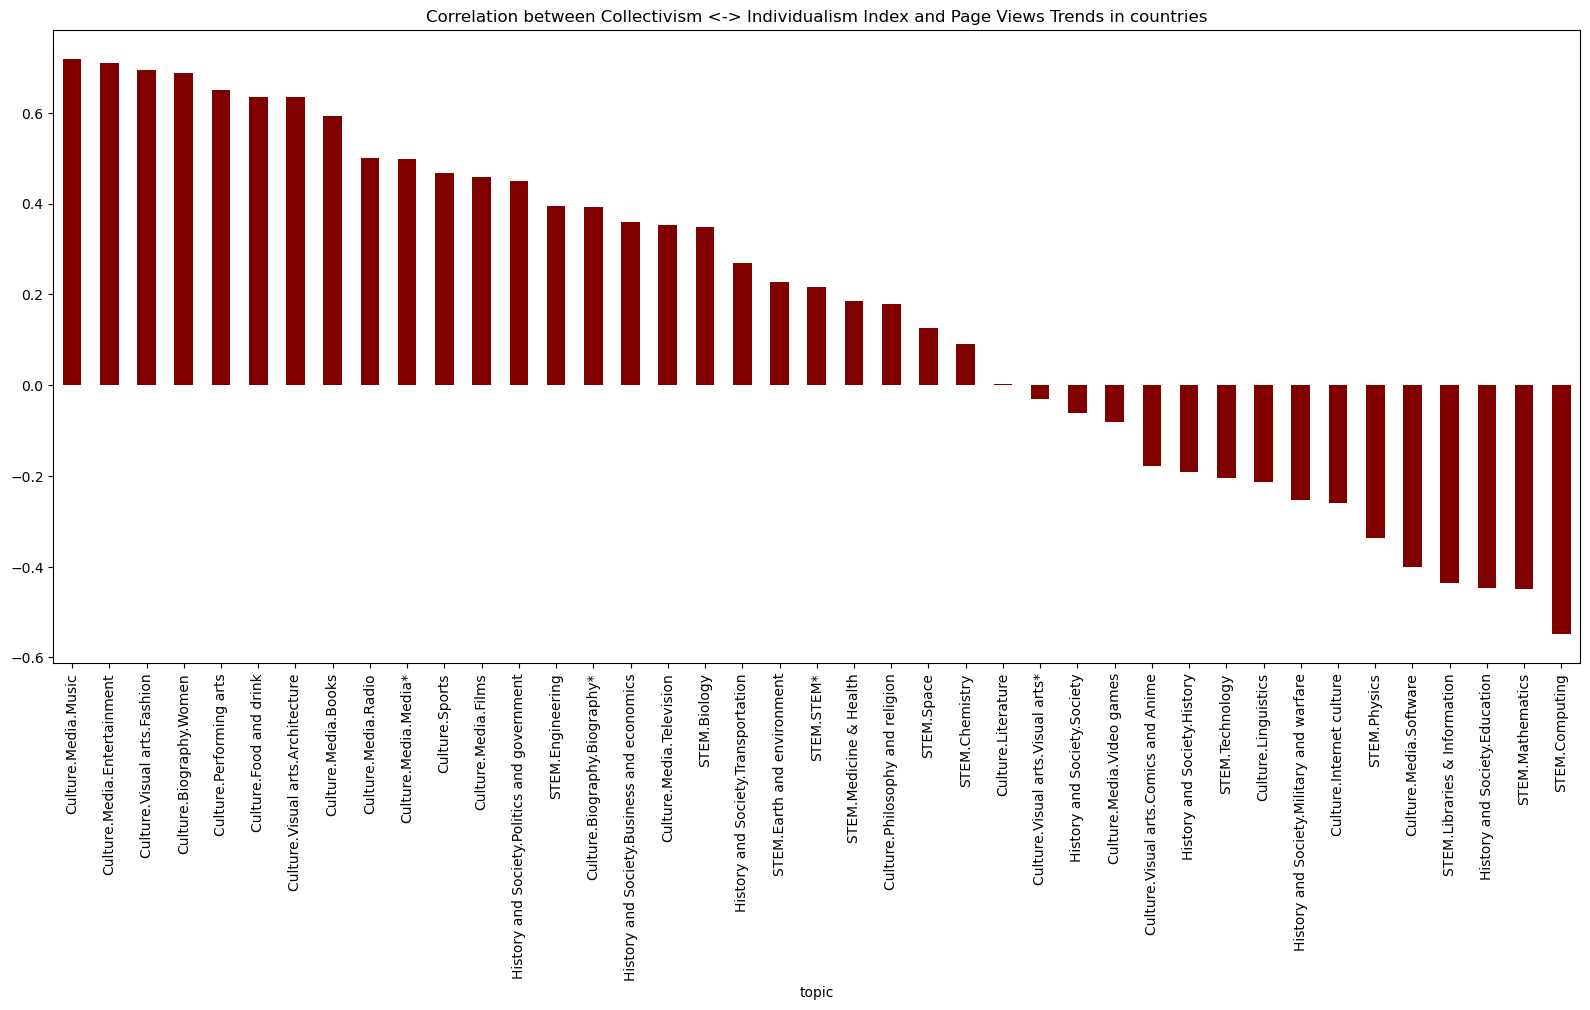

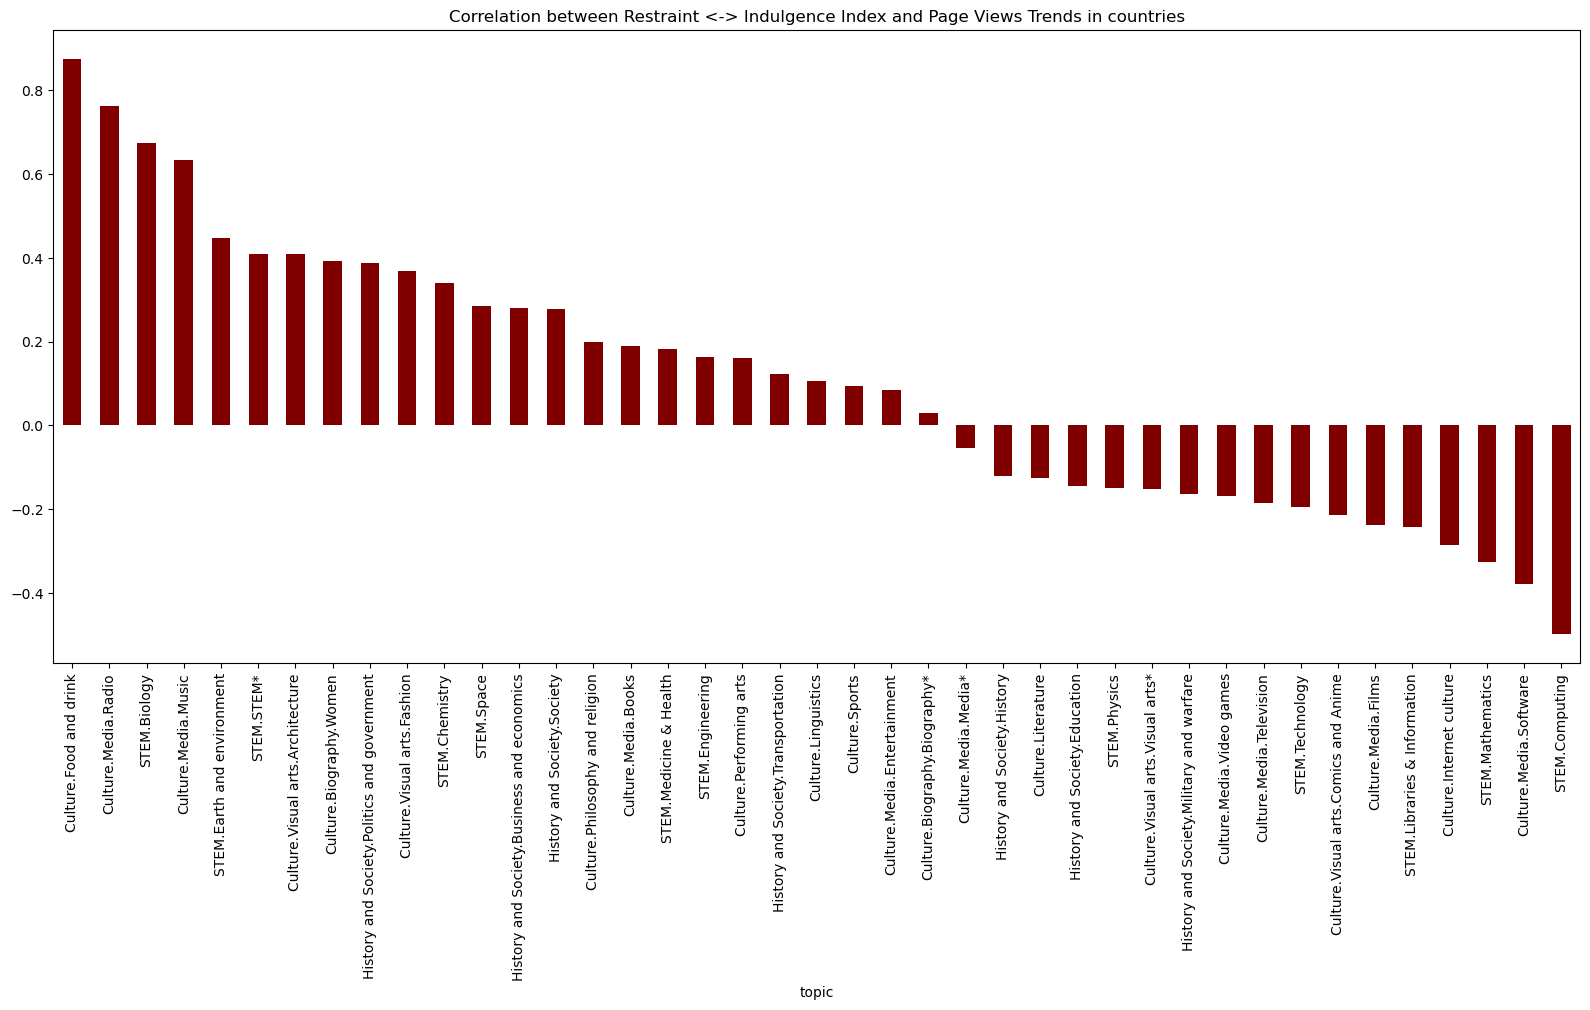

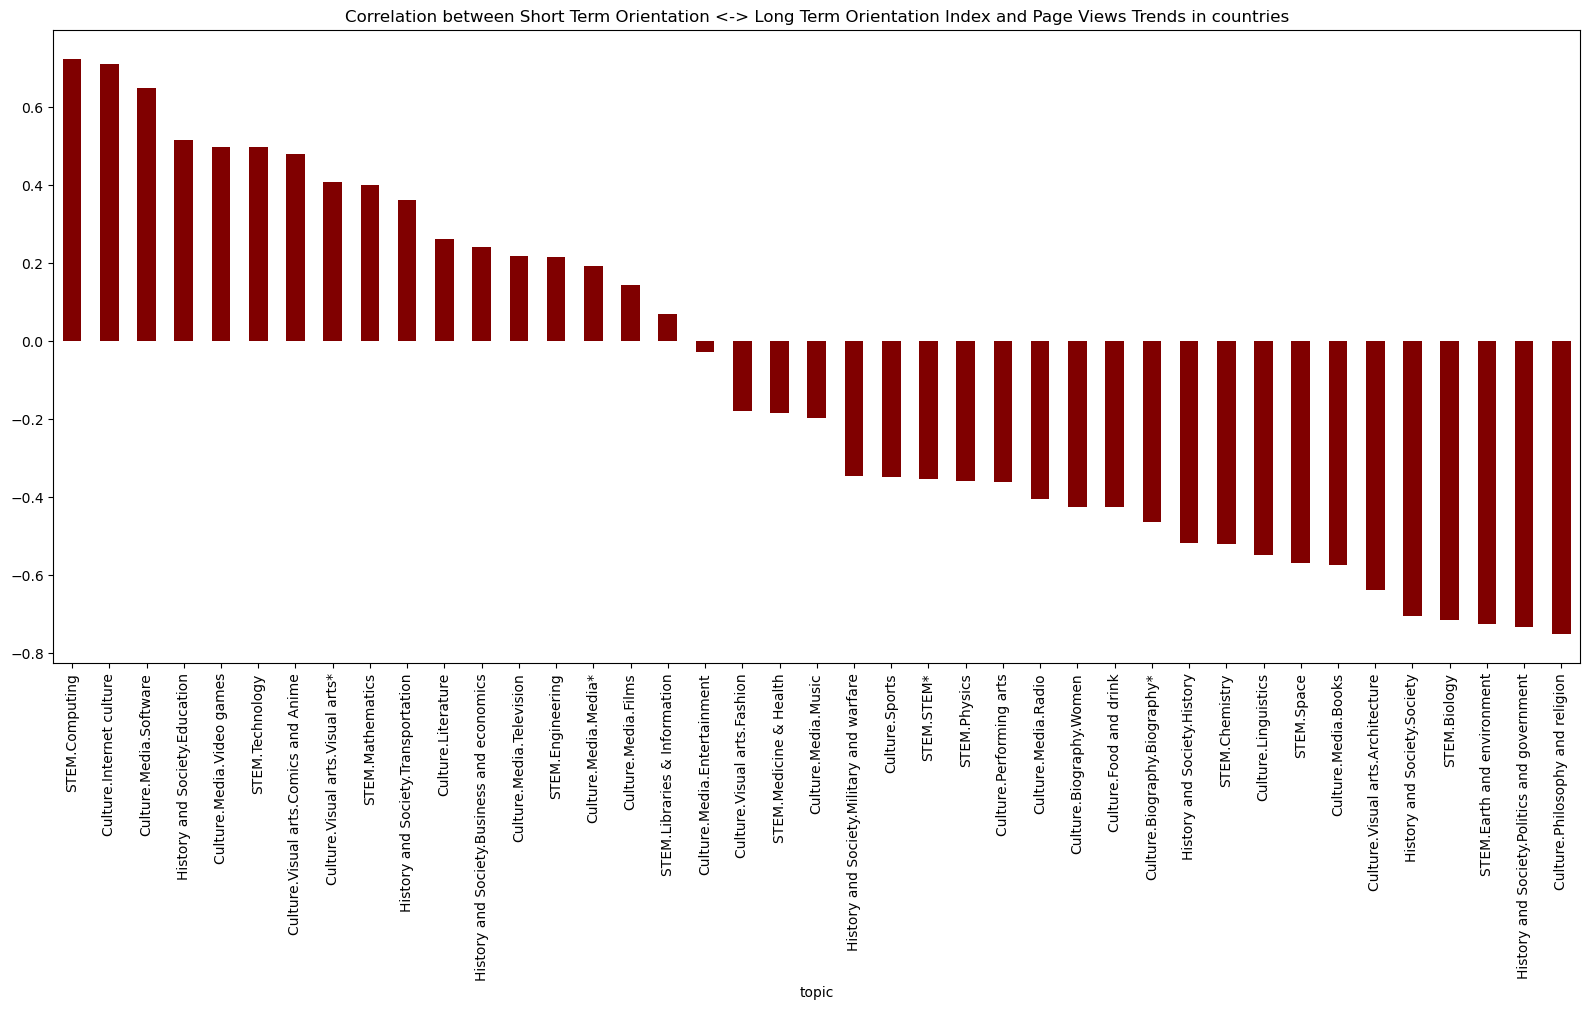

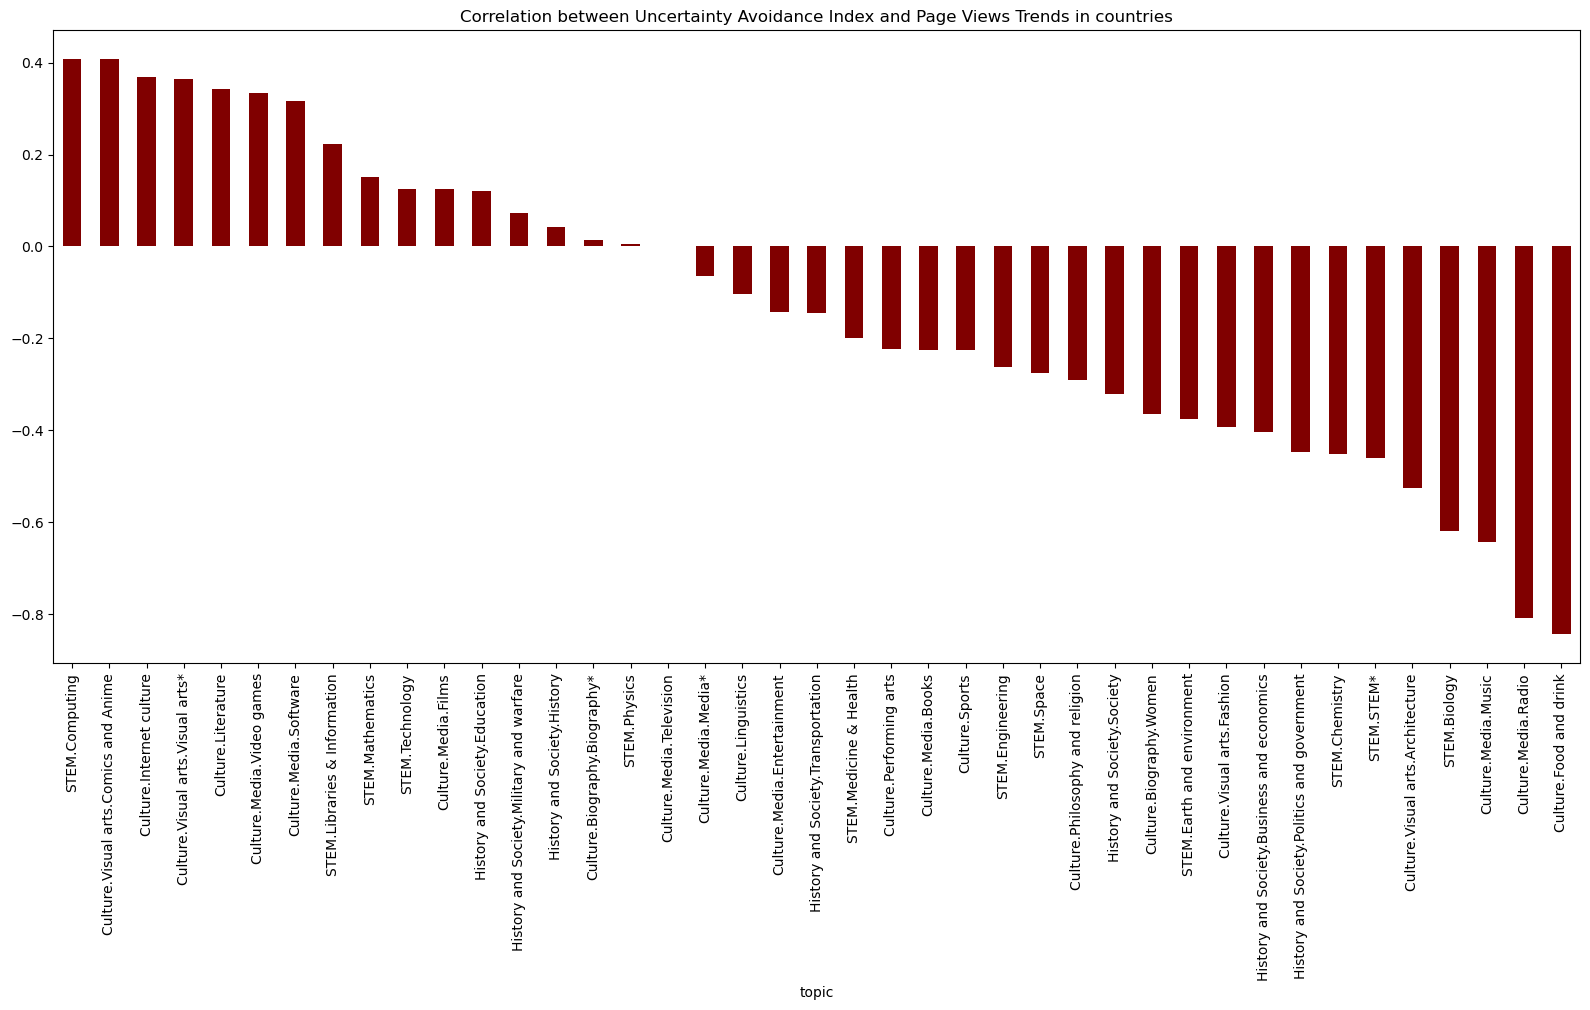

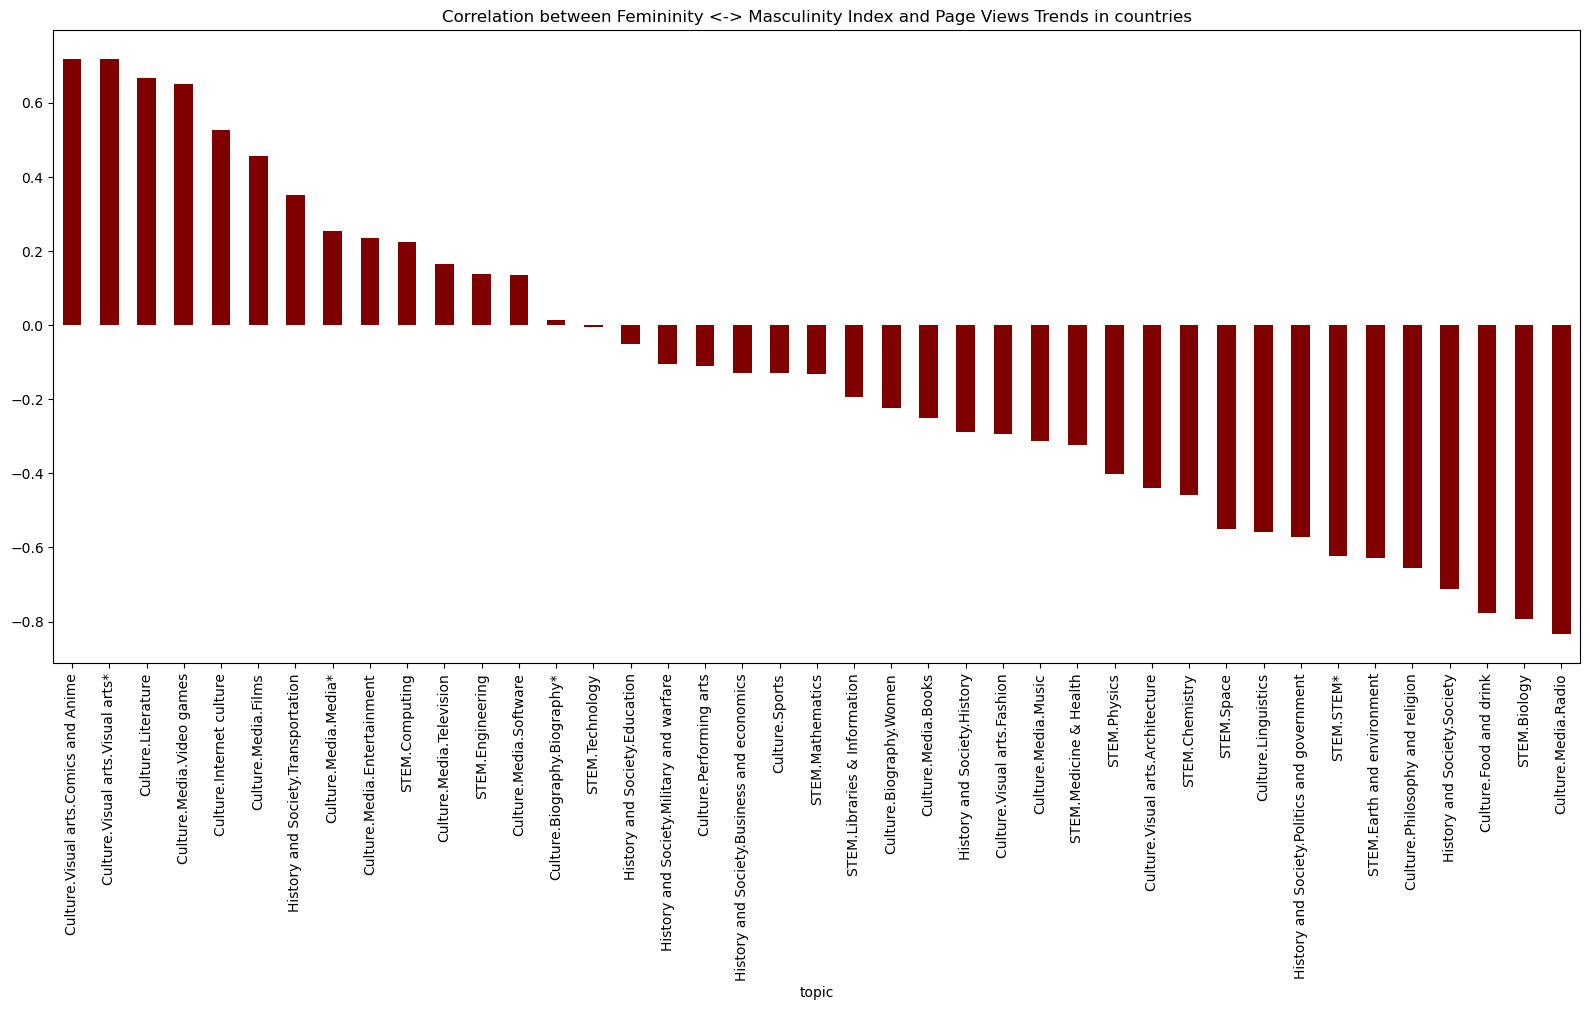

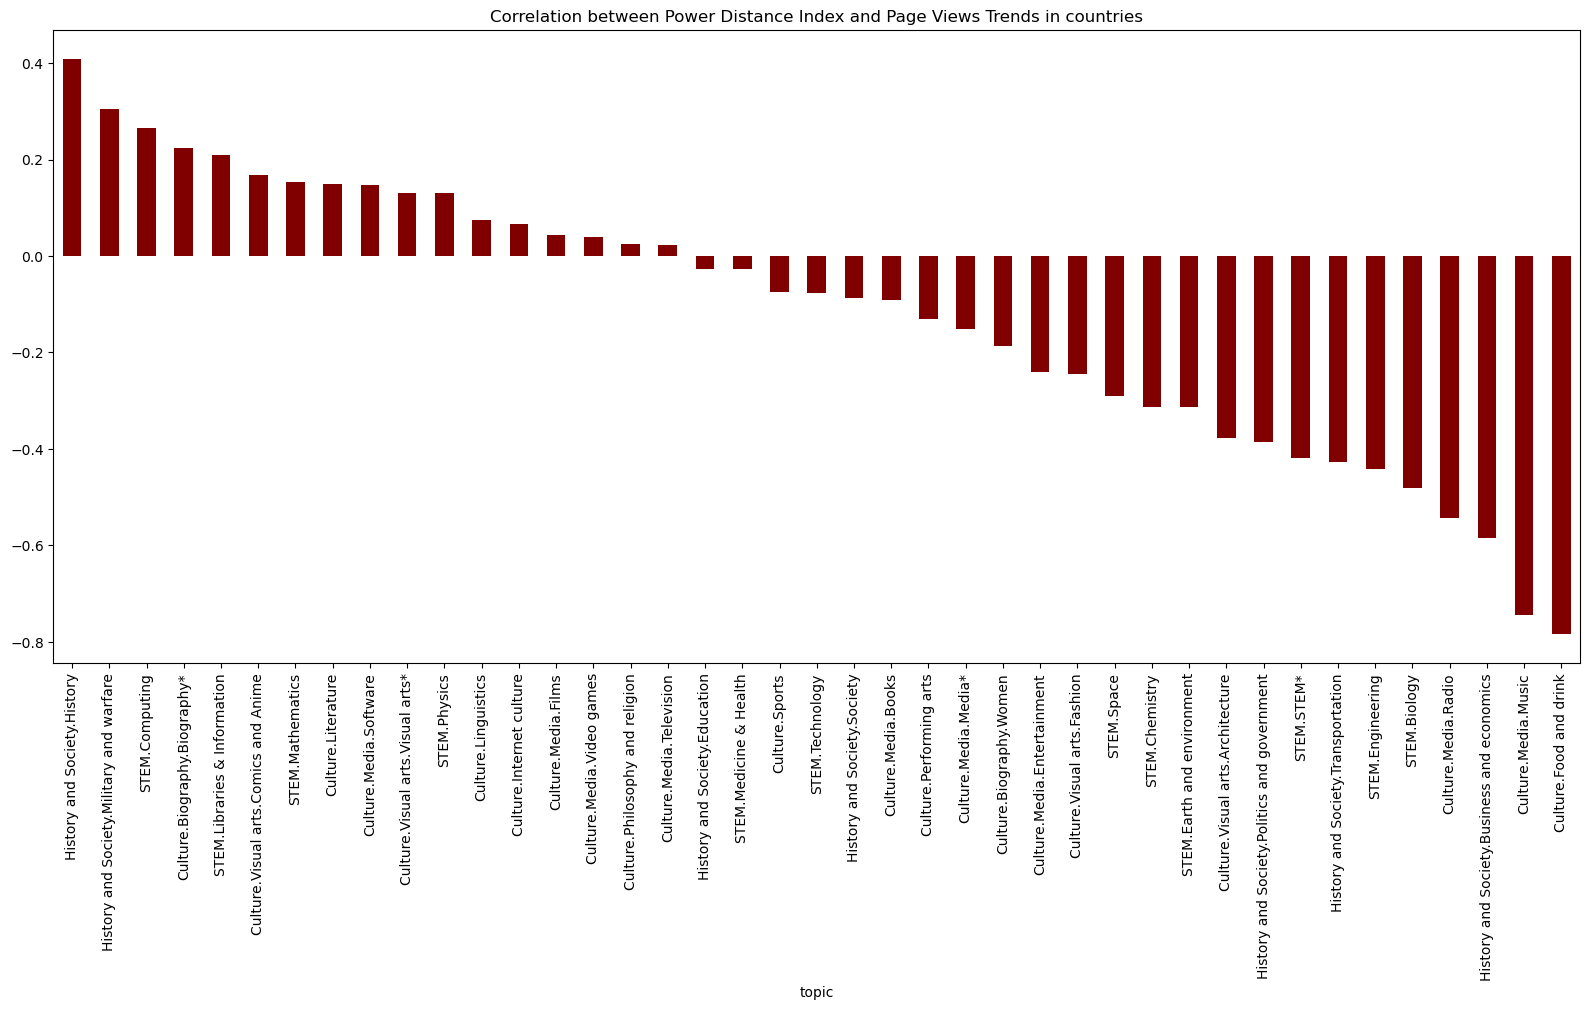

In [44]:
dimensions = {'idv': 'Collectivism <-> Individualism Index', 'ivr' : 'Restraint <-> Indulgence Index', 'ltowvs' : 'Short Term Orientation <-> Long Term Orientation Index', 'uai': 'Uncertainty Avoidance Index', 'mas': 'Femininity <-> Masculinity Index', 'pdi': 'Power Distance Index'}
for dim, description in dimensions.items():
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    pre_covid_corr_df[dim].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
    fig.tight_layout()
    ax.set_title("Correlation between " + description + " and Page Views Trends in countries")

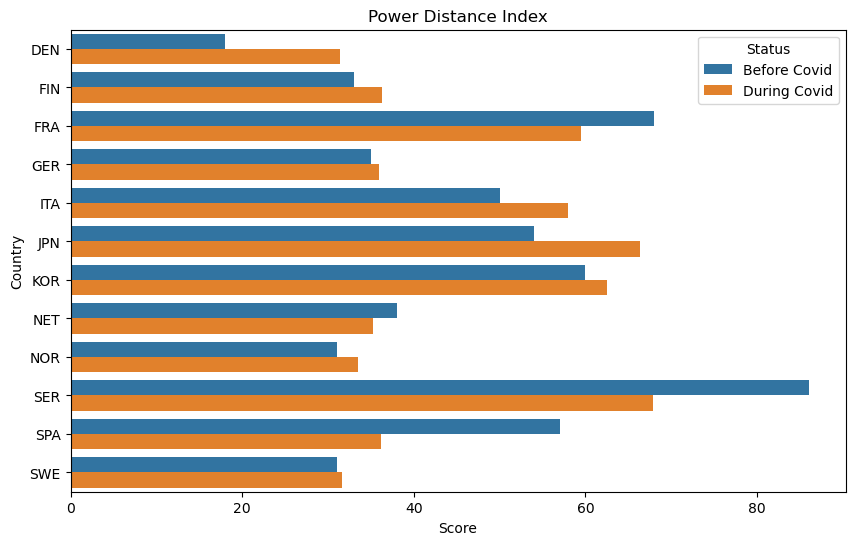

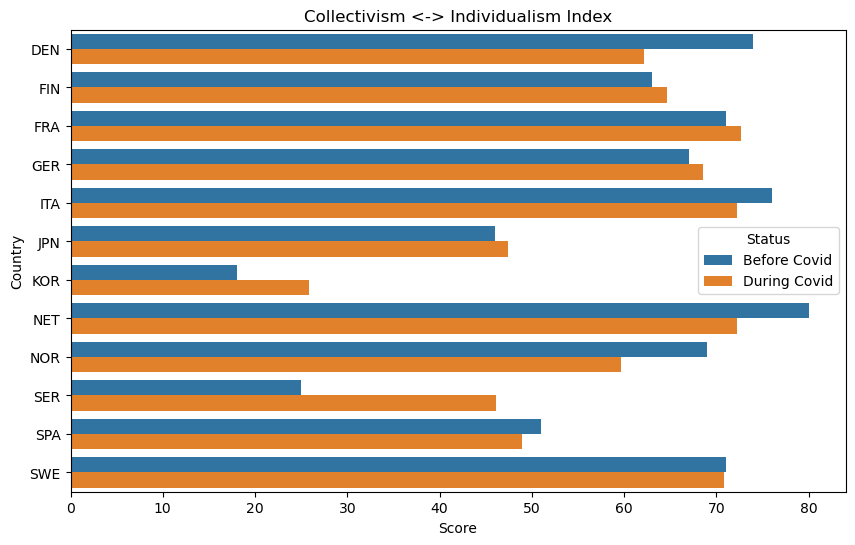

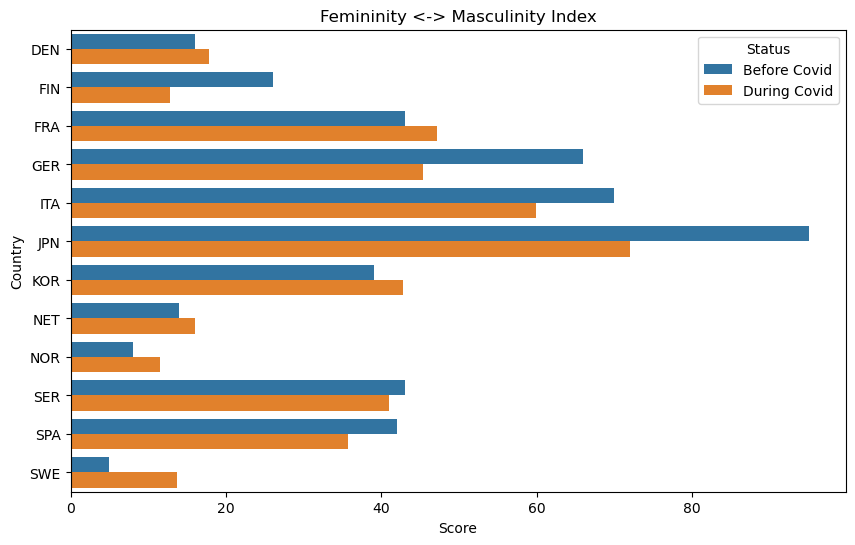

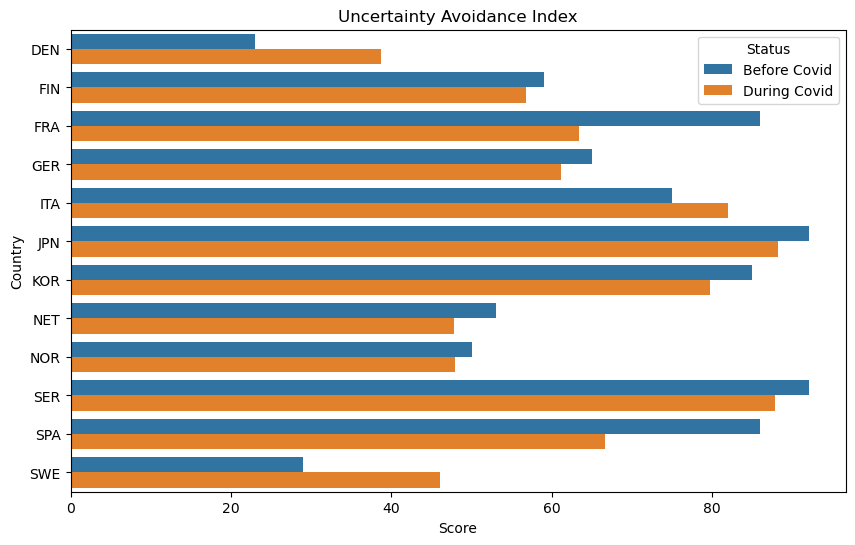

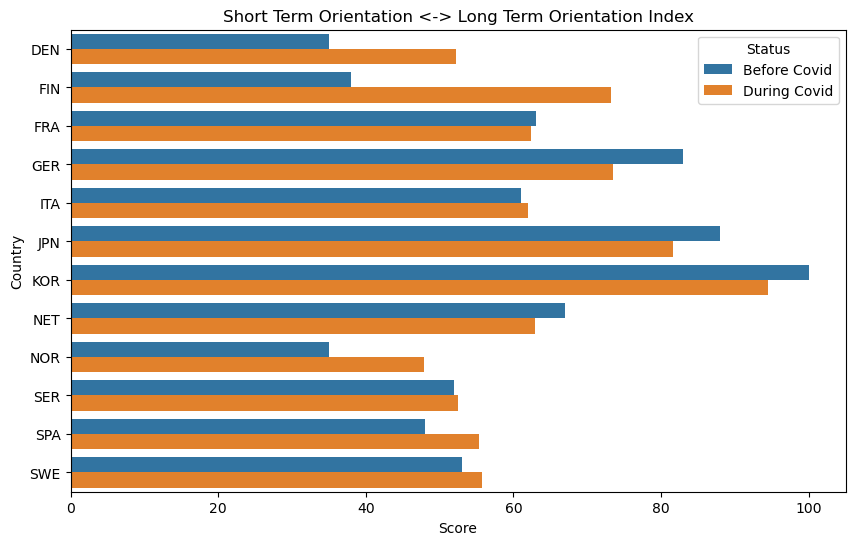

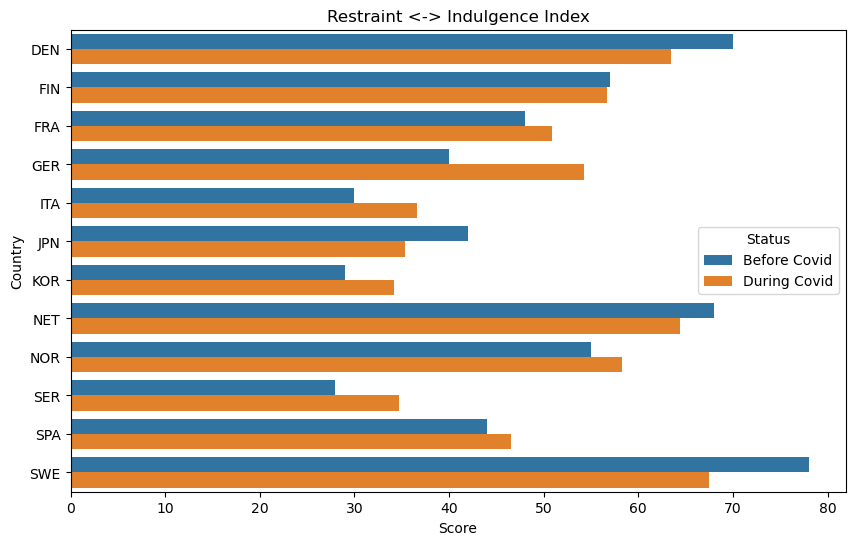

In [45]:
for dim in hofstede.columns:
    X = pre_covid_prop.pivot_table(index='language', columns='topic', values='median')
    X.index = X.index.map(code_dict)
    X = X.sort_index()
    X = X.rename_axis('ctr', axis='index')
    
    y = hofstede[dim]
    rf_regressor = RandomForestRegressor(n_estimators=15, random_state=42)
    rf_regressor.fit(X, y)
    
    # Remove uncorrelated features
    feature_importances = rf_regressor.feature_importances_
    threshold = 0.05  # Set your threshold value
    features_to_remove = X.columns[feature_importances < threshold]
    X = X.drop(features_to_remove, axis=1)
    rf_regressor.fit(X, y)
    
    
    Xnew = dur_covid_prop.pivot_table(index='language', columns='topic', values='median')
    Xnew.index = Xnew.index.map(code_dict)
    Xnew = Xnew.sort_index()
    Xnew = Xnew.rename_axis('ctr', axis='index')
    Xnew = Xnew.drop(features_to_remove, axis=1)
    
    y_pred = rf_regressor.predict(Xnew)
    y_pred = pd.Series(y_pred, index=y.index)

    data = pd.DataFrame({
        'Country': list(y.index) * 2,
        'Score': list(y.values) + list(y_pred.values),
        'Status': ['Before Covid'] * len(y.index) + ['During Covid'] * len(y.index)
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y='Country', x='Score', hue='Status', data=data)
    plt.title(dimensions[dim])

/Users/Paolo/opt/anaconda3/envs/ADA/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.5553487860521487


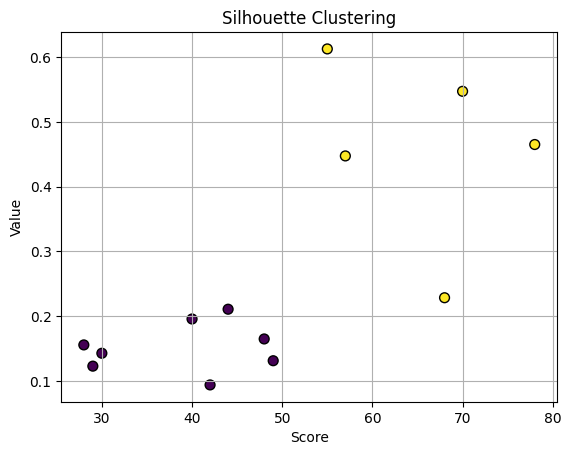

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



# Standardize the data (optional but recommended for KMeans)
scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)
pipeline = make_pipeline(scaler, kmeans)

# Fit the KMeans model
df__['Cluster'] = pipeline.fit_predict(df__[['Hofstede Score', 'Topics views']])

# Calculate silhouette score
silhouette_avg = silhouette_score(df__[['Hofstede Score', 'Topics views']], df__['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Plot the clustered data
plt.scatter(df__['Hofstede Score'], df__['Topics views'], c=df__['Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title('Silhouette Clustering')
plt.xlabel('Score')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [ ]:
# # Now that we understand which topics relate to which cultural dimensions, we can try to analyse the influence of COVID on cultural 

# for dim in hofstede.columns:
#     topic = np.abs(pre_covid_corr_df[dim]).sort_values().idxmax()
#     pre_covid_proportions = pre_covid_prop.loc[topic]
#     pre_covid_proportions.index = pre_covid_proportions.index.map(code_dict)
#     pre_covid_proportions = pre_covid_proportions.sort_index()
    
#     x = pre_covid_proportions.values.flatten()
#     y = hofstede[dim].values
#     plt.figure()
#     plt.scatter(x, y, color='orange', label='Pre covid')
#     plt.grid(True)
#     for i, label in enumerate(pre_covid_proportions.index):
#         plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

#     m, c = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + c, color='red', linestyle=(0, (5, 10)), label='Pre covid regression line')

#     covid_proportions = covid_prop.loc[topic]
#     covid_proportions.index = covid_proportions.index.map(code_dict)
#     covid_proportions = covid_proportions.sort_index()
#     newx = covid_proportions.values.flatten()
#     plt.scatter(newx,y, color='blue', label='Covid')
#     for i, label in enumerate(pre_covid_proportions.index):
#         plt.annotate(label, (newx[i], y[i]), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=6)

#     m, c = np.polyfit(newx, y, 1)
#     plt.plot(x, m*x + c, color='pink', linestyle=(0, (5, 10)), label='Covid regression line')

#     plt.title(dimensions[dim] + ' against ' + topic)
#     plt.xlabel(topic)
#     plt.ylabel(dimensions[dim])
#     plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
